#**Preparations of the environment**#
check that all the imports are used!!!



In [264]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

#to visualize data
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from numpy import array

#to save models
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [265]:
#test if we can access to drive
!ls '/content/gdrive/My Drive/Colab Notebooks'

 dlai_2019_lab01_tensors_todo.ipynb	      'Mon Bienvenue dans Colaboratory'
 dlai_2019_lab02_backprop_todo.ipynb	       myDecoder0.pt
 dlai_2019_lab03_regressor_todo.ipynb	       myDecoder1.pt
 dlai_2019_lab04_mlp_todo.ipynb		       myDecoder2.pt
 dlai_2019_lab05_cnn_todo.ipynb		       myDecoder3.pt
 dlai_2019_lab06_overfitting_todo.ipynb        myEncoder0.pt
 dlai_2019_lab07_interpretability_todo.ipynb   myEncoder1.pt
'dlai_2019_lab08_rnn_todo (1).ipynb'	       myEncoder2.pt
 dlai_2019_lab08_rnn_todo.ipynb		       myEncoder3.pt
 dlai_2019_lab09_transfer_todo.ipynb	      '[My local] ProjectDLAI.ipynb'
 dlai-2019-lab09-transfer_todo.ipynb	      'OLD for DLAI project'


In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':100,
    'num_epochs':7,
    'num_classes':10,
    'learning_rate':1e-3,
    'log_interval':100,
    'train_percentage':0.95,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

#**EXERCISE 1 : Convolutional Autoencoder**

##1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.




In [267]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
initial_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_size = int(hparams['train_percentage'] * len(initial_data))
validation_size = len(initial_data) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(initial_data, [train_size, validation_size])
test_dataset = test_data

print("Train data length:", len(train_dataset))
print("Validation data length:", len(validation_dataset))
print("Test data length:", len(test_dataset))
print()

# data loaders by choosing batch_size
batch_size = 20 #number of samples per batch

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=hparams['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=hparams['batch_size'], shuffle=True)

# check if the loaders are working
# We can retrieve a sample from the dataset by simply indexing it (cf lab 04)
img, label = train_dataset[0]
print('Training img shape: ', img.shape, 'with this label: ', label)
img, label = validation_dataset[0]
print('Validation img shape: ', img.shape, 'with this label: ', label)
img, label = test_dataset[0]
print('Testing img shape: ', img.shape, 'with this label: ', label)



Train data length: 57000
Validation data length: 3000
Test data length: 10000

Training img shape:  torch.Size([1, 28, 28]) with this label:  0
Validation img shape:  torch.Size([1, 28, 28]) with this label:  3
Testing img shape:  torch.Size([1, 28, 28]) with this label:  7


## 2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).

**a) preparation**


In [0]:
# counts the number of parameters of a model
def model_params(model):
    # from: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
    number_of_paremeters=0
    for parameter in list(model.parameters()):
        neural_network=1
        for size_index in list(parameter.size()):
            neural_network = neural_network*size_index
        number_of_paremeters += neural_network
    return number_of_paremeters

**b) encoder**

In [323]:
class encode(nn.Module):
  ## encode ##
  def __init__(self, bottleneck):
    super(encode, self).__init__()
    
    # conv layer (depth from 1 to 16), 3x3 kernels
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1) 
    
    # conv layer (depth from 16 to 4), 3x3 kernels
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    
    #ReLU function
    self.relu = nn.ReLU()

    # pooling layer to reduce x-y dims by two; kernel and stride of 2
    self.pool = nn.MaxPool2d(2, 2)


  def forward(self,x):
    x = self.relu(self.conv1(x)) 
    x = self.pool(x)
    
    # add hidden layer
    x = self.relu(self.conv2(x)) 
    x = self.pool(x)

    # bottlneck layer just before output
    #x = x.view(hparams['batch_size'], -1)
    #x = nn.Linear(4*7*7, bottleneck)(x)

    return x

myEncoder = encode(10)
print(myEncoder)
print("myEncoder has",model_params(myEncoder), "parameters")

encode(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
myEncoder has 740 parameters


**c) decoder**

In [324]:
class decode(nn.Module):
  def __init__(self, bottleneck):
    super(decode, self).__init__()
    ## decoder layers ##
    
    #ReLU function
    self.relu = nn.ReLU()

    ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
    self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    #sigmoid function
    self.sigmoid = nn.Sigmoid()

  def forward(self,code):
    ## decode ##

    # bottlneck layer just before transpose
    #x = nn.Linear(bottleneck, 4*7*7)(code)  #4*7*7

    # add transpose conv layers, with relu activation function
    x = self.relu(self.t_conv1(code))

    # output layer (with sigmoid for scaling from 0 to 1)
    x = self.sigmoid(self.t_conv2(x))
    return x


myDecoder = decode(2)
print(myDecoder)
print("myDecoder has",model_params(myDecoder), "parameters")

decode(
  (relu): ReLU()
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (sigmoid): Sigmoid()
)
myDecoder has 337 parameters



## 3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

In [0]:
def train_epoch(train_loader, EncoderModel, DecoderModel, optimizer, criterion, hparams, epoch):
  # Activate the train=True flag inside the model
  EncoderModel.train()
  DecoderModel.train()
  
  #initiate loss to 0
  loss = 0.0
  losses = []

  for batch_idx, (data) in enumerate(train_loader, 1):
      data = data[0].to(hparams['device']) #index 0 is for image, index 1 for the labels
      optimizer.zero_grad()

      #compute the output
      firstOutput = EncoderModel(data)
      outputs = DecoderModel(firstOutput)
      
      #compare it to the input data
      loss = criterion(outputs, data)
      
      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
          
  return losses # one epoch returns (training_loader_size / batch_size) loss points (here 570)


In [0]:
# we need to add accuracy in there (TODO)
def eval_epoch(eval_loader,  EncoderModel, DecoderModel, criterion, hparams, printing=True):
  # Activate the validation=True flag inside the model
  EncoderModel.eval()
  DecoderModel.eval()
  
  eval_loss = 0
  eval_losses = []
  with torch.no_grad():
      for data in eval_loader:
          data = data[0].to(hparams['device']) #index 0 is for image, index 1 for the labels

          #compute the output
          firstOutput = EncoderModel(data)
          outputs = DecoderModel(firstOutput)

          #same as in training cause we have an autoencoder
          eval_loss += criterion(outputs, data).item() # sum up batch loss
          
      eval_loss /=len(eval_loader)

  if printing:
    print('Eval set: Average loss: {:.15f}'.format(eval_loss))
  return eval_loss

In [0]:

criterion = nn.MSELoss()

# we will need to define bottleneck numbers (TODO)
def train_autoencoder(bottleneck, myEncoder, myDecoder):
  train_losses = []
  eval_losses = []
  test_losses = []

  myEncoder.to(hparams['device'])
  myDecoder.to(hparams['device'])

  #isn't the optimizer for both models parameters?? (check this out: https://github.com/mbsariyildiz/autoencoder-pytorch/blob/master/src/train.py)
  optimizer = optim.Adam(list(myEncoder.parameters()) + list(myDecoder.parameters()), lr=hparams['learning_rate'])
  
  for epoch in range(1, hparams['num_epochs'] + 1):
    tr_loss = train_epoch(train_loader, myEncoder, myDecoder, optimizer, criterion, hparams, epoch)
    te_loss = eval_epoch(validation_loader, myEncoder, myDecoder, criterion, hparams)
    train_losses.append(tr_loss)
    eval_losses.append(te_loss)
    
    #early stopping if generalization is too wide: evaluation loss is 30% bigger than training loss (TODO)
    #if ((te_loss-np.mean(tr_loss)) > np.mean(tr_loss)*30% ):
      #print("EARLY STOPPING HERE BECAUSE ", te_loss, " >>> ", np.mean(tr_loss))
      #break


  return myEncoder, myDecoder, train_losses, eval_losses, test_losses

In [0]:
#let's now train it
myEncoders = []
myDecoders = []
myTrain_losses = []
myEval_losses = []

bottlenecks = range(0,10,3)
bottlenecks = range(1,2,3) #only ONE bottleneck

for bottleneck_size in bottlenecks: #0, 3, 6 and 9
  print("\n***************** BOTTLENECK SIZE:",bottleneck_size," ************************")
  #initialize models
  myEncoder = encode(bottleneck)  
  myDecoder = decode(bottleneck)

  myTrainResults = train_autoencoder(bottleneck_size, myEncoder, myDecoder)
  myEncoders.append(myTrainResults[0])
  myDecoders.append(myTrainResults[1])
  myTrain_losses.append(myTrainResults[2])
  myEval_losses.append(myTrainResults[3])



In [0]:
number_of_models = range(0,len(myTrain_losses),1)

In [409]:
# ********************** Save the models to new files (OPTIONAL) **************************
def save_models():
  for i in number_of_models:
    model_save_name = 'myEncoder' + str(i) + '.pt'
    path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
    torch.save(myEncoders[i].state_dict(), path)
    
    model_save_name = 'myDecoder' + str(i) + '.pt'
    path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
    torch.save(myDecoders[i].state_dict(), path)

  print(2*len(myTrain_losses),"models saved.")

def load_model(modelname, modelClass):
  
  path = F"/content/gdrive/My Drive/Colab Notebooks/" + modelname +'.pt'
  modelClass.load_state_dict(torch.load(path))
  
  print(modelname + " loaded.")

#Save
save_models()

2 models saved.


In [410]:
# ****************************** check if we have saved the models (OPTIONAL) ******************************
myEnc = encode(0)
myDec = decode(0)
load_model("myEncoder0",myEnc)
load_model("myDecoder0",myDec)

myEncoder0 loaded.
myDecoder0 loaded.


7


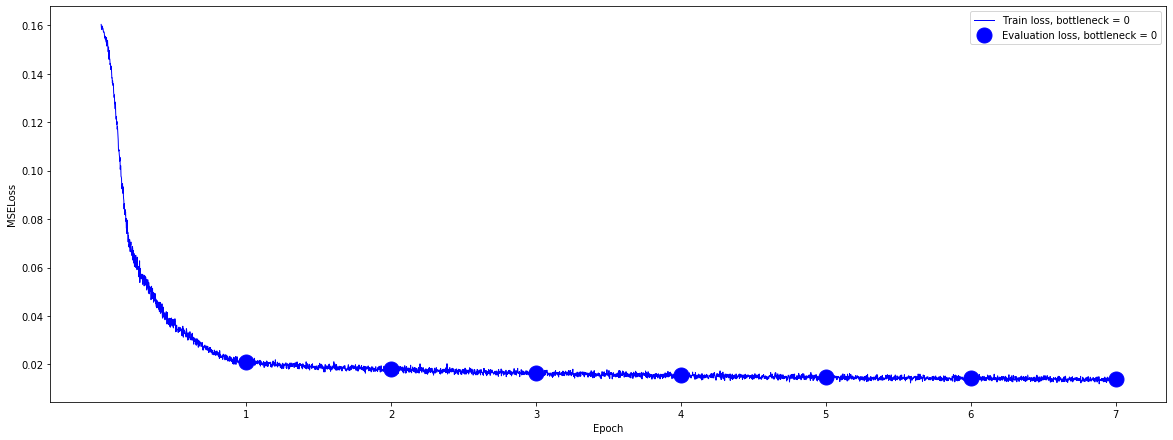

In [351]:
# **************************** WE PLOT CURVES AND LOSS POINTS HERE ****************************

plt.figure(figsize=(20, 16))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

print(len(myEval_losses[0]))

#we place the average validation loss points at the end of every epoch
general_marker_size = 15
general_linewidth = 1
number_of_losspoints_per_epoch = len(train_dataset)/hparams['batch_size']
x_labels = [number_of_losspoints_per_epoch * i for i in range(1,hparams['num_epochs']+1)]
colors = ['blue','orange','red','green']

#plot everything
for model_number in number_of_models:
  plt.plot(list(itertools.chain(*myTrain_losses[model_number])), label='Train loss, bottleneck = '+ str(trainloss_index*3), marker='', linewidth=general_linewidth, color=colors[model_number])
  plt.plot(x_labels,myEval_losses[model_number],label='Evaluation loss, bottleneck = 0', marker='o', markersize=general_marker_size, linewidth=0, color=colors[model_number])

#we replace x labels to epochs
plt.xticks(x_labels, range(1,hparams['num_epochs']+1))

#we add a legend
plt.legend();



## 4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including number of parameters of each model.

In [406]:
# COMPUTE TEST MSE LOSS
test_losses_of_a_model = []
test_losses = []
eval_losses_of_a_model = []
eval_losses = []

for i in number_of_models:
  
  for epoch in range(1, hparams['num_epochs'] + 1):
    
    eval_loss = eval_epoch(validation_loader,  myEncoders[i], myDecoders[i], criterion, hparams, False)
    eval_losses_of_a_model.append(eval_loss)
    
    test_loss = eval_epoch(test_loader,  myEncoders[i], myDecoders[i], criterion, hparams, False)
    test_losses_of_a_model.append(test_loss)

  
  eval_losses.append(eval_losses_of_a_model)
  test_losses.append(test_losses_of_a_model)

  # SHOULD BE AS A TABLE
  print("\n***************** MODEL NUMBER " + str(i) + ' *****************')
  print('Number of bottleneck:',str(0))
  print('image reconstruction error (MSE) on validation set:', np.mean(eval_losses))
  print('image reconstruction error (MSE) on test set:',np.mean(test_losses))
  print('Number of parameters: ', model_params(myEncoders[i]) + model_params(myDecoders[i]))


MODEL NUMBER 0 *****************
Number of bottleneck:0
image reconstruction error (MSE) on validation set: 0.013883227522351911
image reconstruction error (MSE) on test set: 0.013482006091092314
Number of parameters:  1077


## 5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.


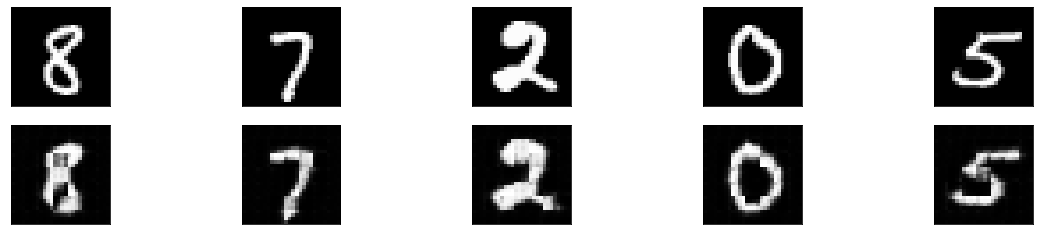

In [360]:
# We choose the one with least MSE Loss (highest bottleneck)
i = 0 #TODO when bottlenecks work
dataiter = iter(test_loader)
images_, labels_ = dataiter.next()

#let's display the input and output here after testing
images, labels = images_, labels_

# get sample outputs (we need to retrieve test_losses)
output = myDecoders[i](myEncoders[i](images))
# prep images for display
images = images.numpy()

# output is resized into a batch of images >>> not needed
output = output.view(hparams['batch_size'], 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          ax.label_outer()



            


## 6. Generate 5 new images by injecting random values as input to the decoder. Show them.

In [0]:
inputs = torch.randn()

# **EXERCISE 2 : Transfer Learning**

## 1. Select a subset of 100 images and their associated labels from the MNIST training data.

## 2. Select one of the previously trained autoencoders.

## 3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

## 4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

## 5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

## 6. From scratch: train the model on the 100 samples without reusing the decoder weights at all.

## 7. Show the accuracy of the four models on the MNIST test set in a table.